In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120)


In [3]:
N=100
Nx=20
rng=np.random.default_rng(seed=123)
arr = np.tile(np.arange(N).reshape(N,1),(1,Nx))
offset = rng.permuted(np.tile(np.arange(1,N),(N,1)), axis=1)[:,:Nx-1]
arr[:,1:]+=offset
arr %= N
x = jnp.asarray(rng.uniform(size=N))
a = rng.uniform(size=(N,Nx))
b = jnp.sum(a*x[arr]**2,axis=1)
x0 = x+rng.uniform(-0.01,0.01,size=N)

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
@jax.jit
def f(x):
    return jnp.sum(a*x[arr]**2,axis=1)-b

In [5]:
res=LM(f,x0, L=1e7, maxiter=1000, ftol=1e-12)

In [7]:
Nside=5
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

N = 12
r=0.2
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
circle = np.stack([r*np.cos(theta)+0.5, r*np.sin(theta)+0.5], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]

In [10]:

A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[0.5, 0.5]])
B = triangle.triangulate(A, 'qpa0.01')

In [11]:
tr=B['triangles']
verts = B['vertices']
interior = np.where(np.ravel(B['vertex_markers'])==0)[0]
Nv = verts.size

In [12]:
def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def five_neighbors(i):
    nb=get_neighbors(i)
    if nb.size<5:
        for ii in nb:
            nb=np.union1d(nb, get_neighbors(ii))
        nb=np.setdiff1d(nb,i)
    d=np.sum((verts[i]-verts[nb])**2,axis=1)
    print(np.c_[nb,d])
    
    return nb[np.argpartition(d,5)[:5]]

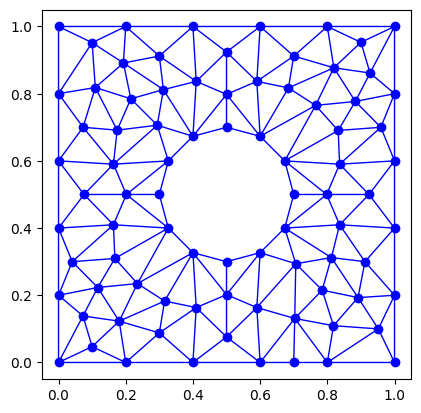

In [48]:
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
_=ax1.triplot(verts[:,0],verts[:,1],'bo-',triangles=tr,lw=1)